In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering, OPTICS
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
import os
import networkx as nx
from collections import defaultdict

Обработка

--- DBSCAN ---
Используем выборку данных из-за ограничений памяти
Время выполнения: 1.02 сек
Всего точек: 30,000
Кластеров: 9
Шумовых точек: 531 (1.8%)


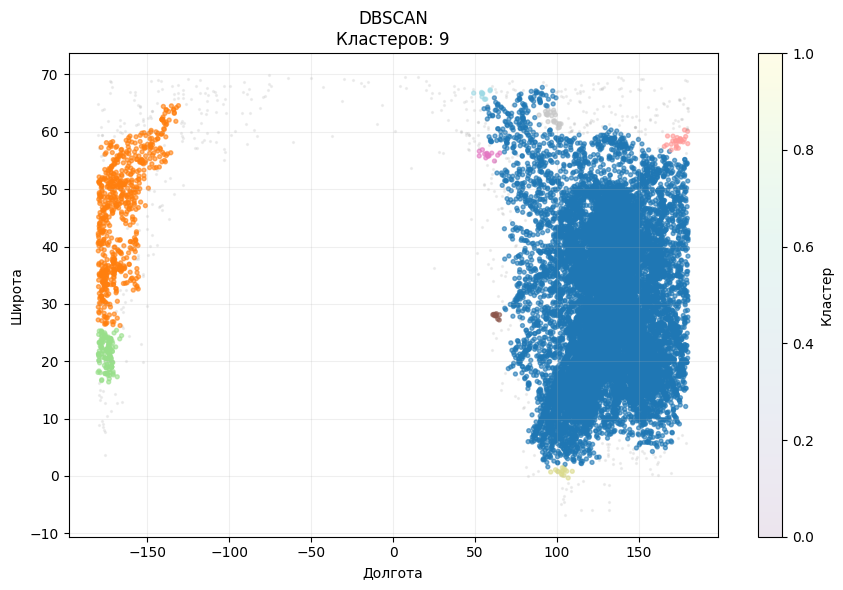


--- KMeans ---
Обработка по чанкам...
Обработано чанков: 10
Обработано чанков: 20
Обработано чанков: 30
Обработано чанков: 40
Обработано чанков: 50
Обработано чанков: 60
Обработано чанков: 70
Обработано чанков: 80
Обработано чанков: 90
Обработано чанков: 100
Время выполнения: 2.73 сек
Всего точек: 30,000
Кластеров: 10
Шумовых точек: 0 (0.0%)


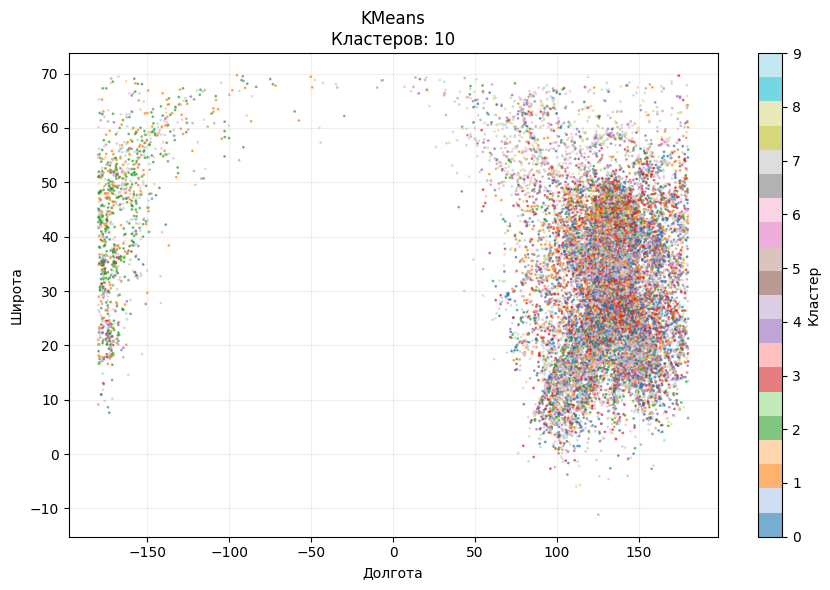


--- Agglomerative ---
Используем выборку данных из-за ограничений памяти
Время выполнения: 72.79 сек
Всего точек: 30,000
Кластеров: 10
Шумовых точек: 0 (0.0%)


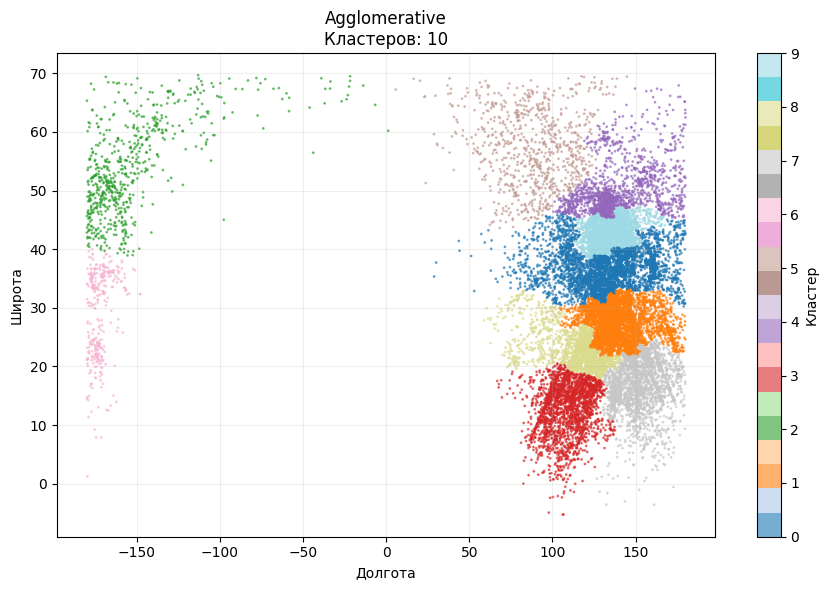

In [6]:
INPUT_FILE = 'data1.csv'
CHUNKSIZE = 10000
N_SAMPLES = 30000
EPS = 0.1
MIN_SAMPLES = 10
N_CLUSTERS = 10


METHODS = {
    'DBSCAN': {
        'model': DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, n_jobs=-1),
        'chunk_process': False
    },
    'KMeans': {
        'model': KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init='auto'),
        'chunk_process': True
    },
    'Agglomerative': {
        'model': AgglomerativeClustering(n_clusters=N_CLUSTERS),
        'chunk_process': False
    },
    # 'OPTICS': {
    #     'model': OPTICS(min_samples=MIN_SAMPLES, xi=0.05, n_jobs=-1),
    #     'chunk_process': False
    # }
}


def load_sample():
    sample = pd.DataFrame()
    for chunk in pd.read_csv(INPUT_FILE, chunksize=CHUNKSIZE):
        sample = pd.concat([sample, chunk.sample(frac=0.1)])
        if len(sample) >= N_SAMPLES:
            break
    return sample.sample(min(N_SAMPLES, len(sample))).reset_index(drop=True)


def process_in_chunks(method_name, model, chunk_process):
    print(f"\n--- {method_name} ---")
    start_time = time.time()

    if not chunk_process:
        print("Используем выборку данных из-за ограничений памяти")
        df = load_sample()
        coords = df[['Долгота', 'Широта']].values
        coords_scaled = StandardScaler().fit_transform(coords)
        labels = model.fit_predict(coords_scaled)
        df['cluster'] = labels
    else:
        print("Обработка по чанкам...")
        df_list = []
        for i, chunk in enumerate(pd.read_csv(INPUT_FILE, chunksize=CHUNKSIZE)):
            coords = chunk[['Долгота', 'Широта']].values
            coords_scaled = StandardScaler().fit_transform(coords)
            chunk['cluster'] = model.fit_predict(coords_scaled)
            df_list.append(chunk)
            if (i+1) % 10 == 0:
                print(f"Обработано чанков: {i+1}")

        df = pd.concat(df_list).sample(min(N_SAMPLES, len(df_list)*CHUNKSIZE))

    noise = df[df['cluster'] == -1]
    clustered = df[df['cluster'] != -1]
    n_clusters = len(clustered['cluster'].unique())

    print(f"Время выполнения: {time.time() - start_time:.2f} сек")
    print(f"Всего точек: {len(df):,}")
    print(f"Кластеров: {n_clusters}")
    print(f"Шумовых точек: {len(noise):,} ({len(noise)/len(df):.1%})")
    plt.figure(figsize=(9, 6))

    viz_sample = df.sample(min(N_SAMPLES, len(df)), random_state=42)

    if -1 in viz_sample['cluster'].values:
        noise = viz_sample[viz_sample['cluster'] == -1]
        clustered = viz_sample[viz_sample['cluster'] != -1]
        plt.scatter(clustered['Долгота'],
                    clustered['Широта'],
                    c=clustered['cluster'],
                    cmap='tab20',
                    s=8,
                    alpha=0.6)
        plt.scatter(noise['Долгота'],
                    noise['Широта'],
                    c='gray',
                    s=2,
                    alpha=0.1,
                    label='Шум')
    else:
        plt.scatter(viz_sample['Долгота'],
                    viz_sample['Широта'],
                    c=viz_sample['cluster'],
                    cmap='tab20',
                    s=1,
                    alpha=0.6)

    plt.title(f"{method_name}\nКластеров: {len(df['cluster'].unique()) - (-1 in df['cluster'].values)}")
    plt.xlabel('Долгота')
    plt.ylabel('Широта')
    plt.colorbar(label='Кластер')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


print("Обработка")
for method_name, config in METHODS.items():
    process_in_chunks(
        method_name=method_name,
        model=config['model'],
        chunk_process=config['chunk_process']
    )

DBSCAN как будто подходит лучше всего, но также мне понравилась кластеризация для Agglomerative, однако она не учитывает шум и работает очень долго


Анализ данных
Всего строк: 1,037,764
\Результаты

Итого:
Всего точек: 1,037,764
Кластеров: 6
Шум точек: 5,278 (0.5%)
Визуализация


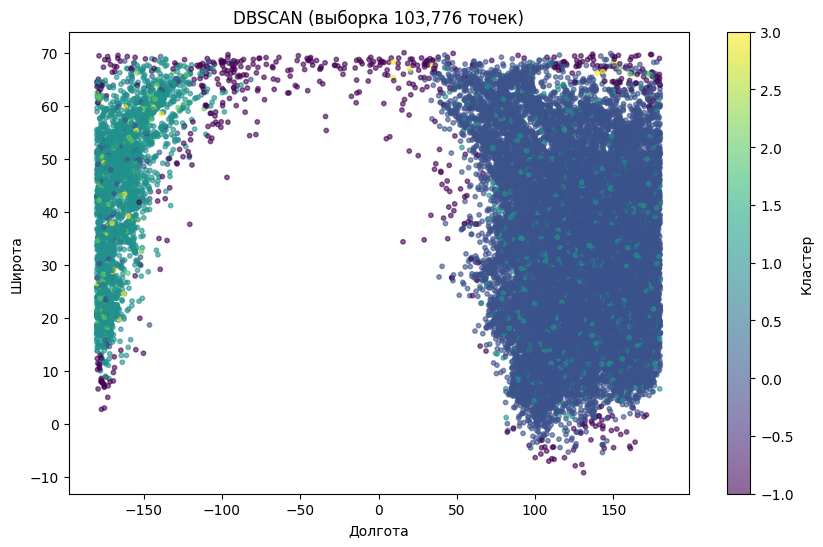


Готово! Результаты сохранены в clustered_data.csv


In [7]:
INPUT_FILE = 'data1.csv'
CHUNKSIZE = 10000
EPS = 0.3
MIN_SAMPLES = 15
SAMPLE_FRACTION = 0.1


print("Анализ данных")
n_rows = sum(1 for _ in open(INPUT_FILE)) - 1
print(f"Всего строк: {n_rows:,}")

output_file = 'clustered_data.csv'
with open(output_file, 'w') as f_out:
    f_out.write('datetime,Долгота,Широта,cluster\n')
    for chunk in pd.read_csv(INPUT_FILE, chunksize=CHUNKSIZE):
        coords = chunk[['Долгота', 'Широта']].values
        coords_scaled = StandardScaler().fit_transform(coords)
        db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, n_jobs=-1).fit(coords_scaled)
        chunk['cluster'] = db.labels_
        chunk.to_csv(f_out, header=False, index=False, mode='a')


print("\Результаты")
cluster_counts = {}
noise_count = 0
total = 0
for chunk in pd.read_csv(output_file, chunksize=CHUNKSIZE):
    for cluster in chunk['cluster']:
        total += 1
        if cluster == -1:
            noise_count += 1
        else:
            cluster_counts[cluster] = cluster_counts.get(cluster, 0) + 1

print(f"\nИтого:")
print(f"Всего точек: {total:,}")
print(f"Кластеров: {len(cluster_counts)}")
print(f"Шум точек: {noise_count:,} ({noise_count/total:.1%})")


sample = pd.read_csv(output_file).sample(frac=SAMPLE_FRACTION)
print("Визуализация")
plt.figure(figsize=(10, 6))
plt.scatter(sample['Долгота'],
            sample['Широта'],
            c=sample['cluster'],
            s=10,
            alpha=0.6)
plt.colorbar(label='Кластер')
plt.title(f"DBSCAN (выборка {len(sample):,} точек)")
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()

print("\nГотово! Результаты сохранены в", output_file)

In [8]:
df = pd.read_csv('clustered_data.csv', parse_dates=['datetime'])

MIN_POINTS_IN_CLUSTER = 100


cluster_sizes = df['cluster'].value_counts()
small_clusters = cluster_sizes[cluster_sizes < MIN_POINTS_IN_CLUSTER].index
df['cluster'] = df['cluster'].where(~df['cluster'].isin(small_clusters), -1)
cluster_counts = df['cluster'].value_counts().sort_index()


print("Количество точек по кластерам:")
for cluster_id, count in cluster_counts.items():
    if cluster_id == -1:
        print(f"Шумовые точки: {count}")
    else:
        print(f"Кластер {cluster_id}: {count} точек")

<ipython-input-8-2d36db6efa1c>:1: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('clustered_data.csv', parse_dates=['datetime'])


Количество точек по кластерам:
Шумовые точки: 5303
Кластер 0: 938516 точек
Кластер 1: 91690 точек
Кластер 2: 1832 точек
Кластер 3: 423 точек


Кластер 0: найдено 2133 циклов


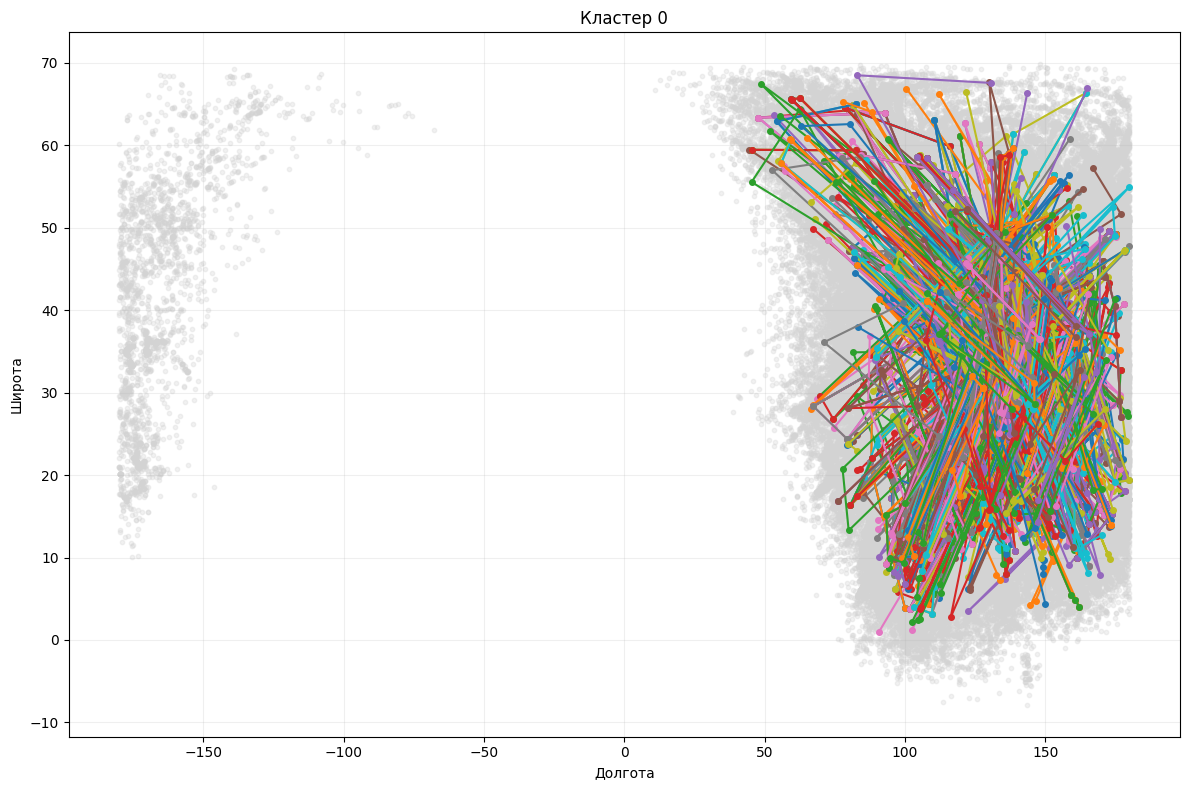

Кластер 1: найдено 19 циклов


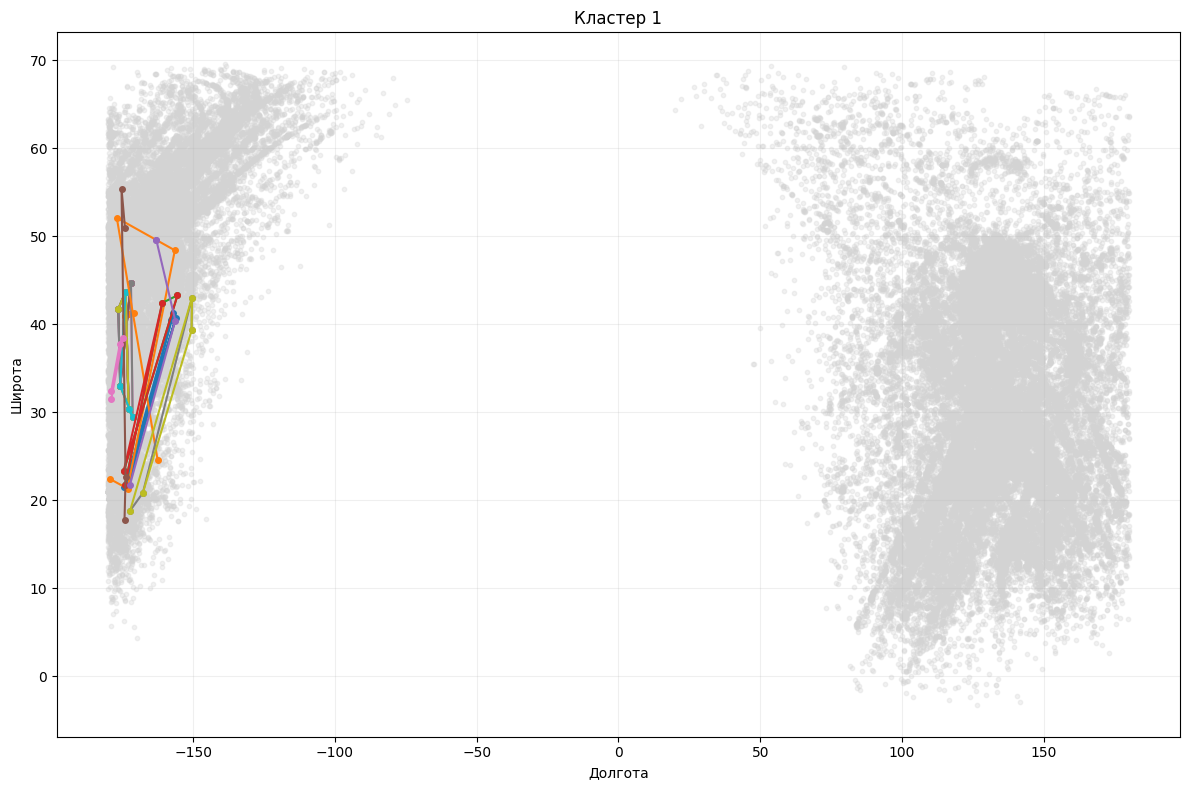

Кластер 2: циклы не найдены


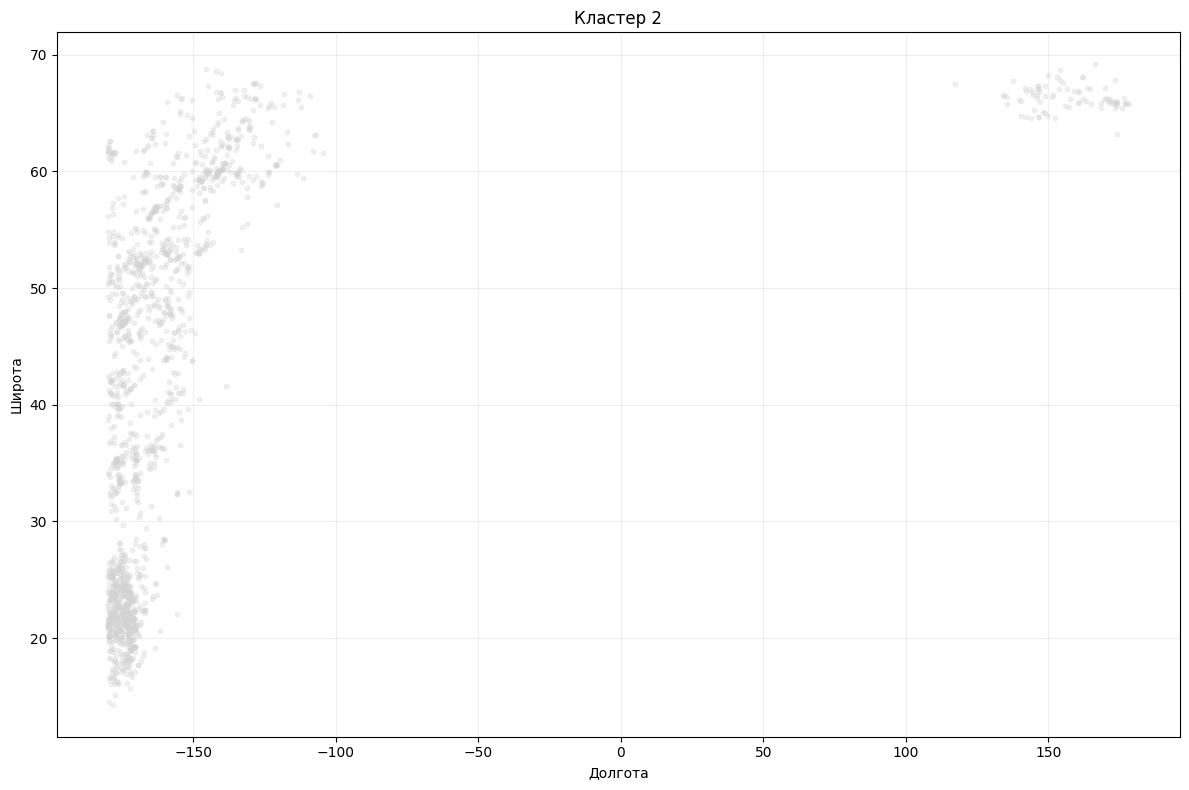

Кластер 3: циклы не найдены


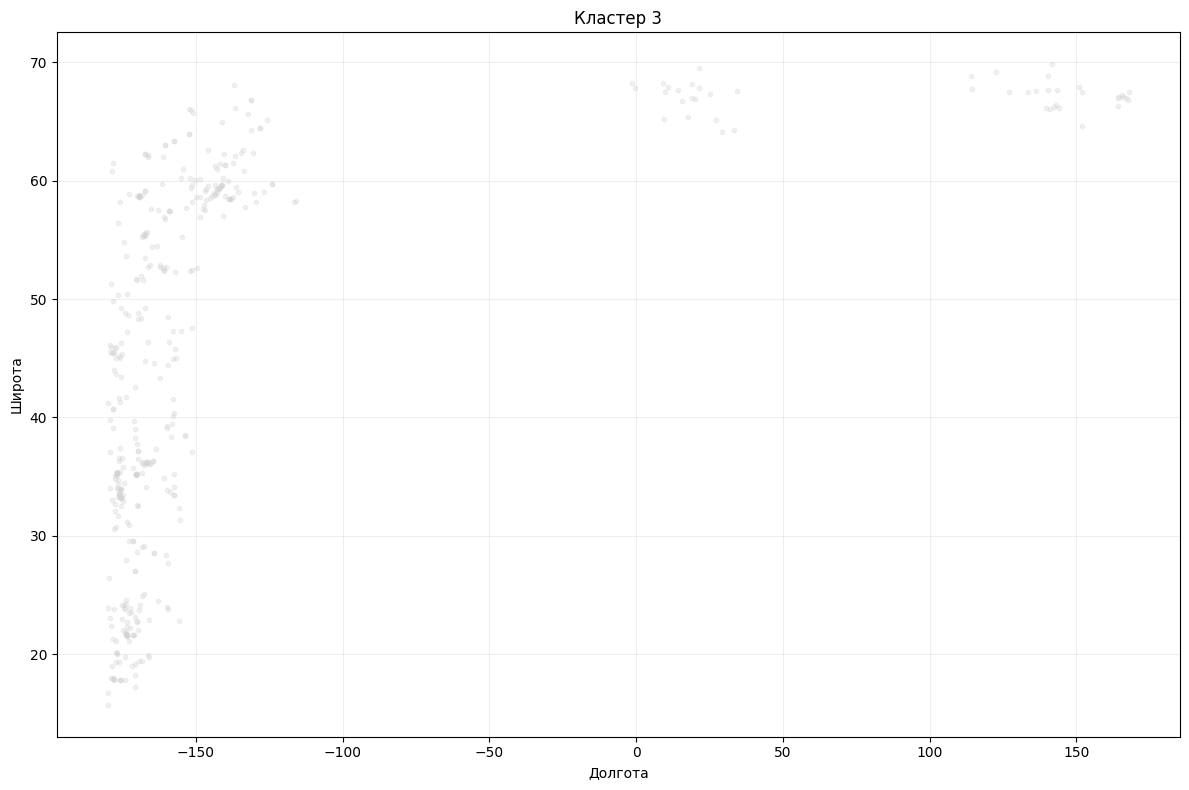

In [9]:
# df = pd.read_csv('clustered_data.csv', parse_dates=['datetime'])

def find_cycles_in_cluster(cluster_df, min_length=4):
    cluster_df = cluster_df.sort_values('datetime')

    G = nx.DiGraph()
    unique_points = set()

    for _, row in cluster_df.iterrows():
        point = (row['Долгота'], row['Широта'])
        unique_points.add(point)

    for point in unique_points:
        G.add_node(point)

    prev_point = None
    for _, row in cluster_df.iterrows():
        current_point = (row['Долгота'], row['Широта'])
        if prev_point is not None and prev_point != current_point:
            if not G.has_edge(prev_point, current_point):
                G.add_edge(prev_point, current_point)
        prev_point = current_point
    cycles = []
    try:
        for cycle in nx.simple_cycles(G):
            if len(cycle) >= min_length:
                cycles.append(cycle)
    except nx.NetworkXNoCycle:
        pass

    return cycles


for cluster_id in df['cluster'].unique():
    if cluster_id == -1:
        continue

    cluster_df = df[df['cluster'] == cluster_id]
    cycles = find_cycles_in_cluster(cluster_df)

    plt.figure(figsize=(12, 8))
    plt.scatter(cluster_df['Долгота'], cluster_df['Широта'],
                color='lightgray', s=10, alpha=0.3, label='Все точки')

    if not cycles:
        print(f"Кластер {cluster_id}: циклы не найдены")
    else:
        print(f"Кластер {cluster_id}: найдено {len(cycles)} циклов")
        for i, cycle in enumerate(cycles):
            cycle_df = pd.DataFrame(cycle, columns=['Долгота', 'Широта'])
            plt.plot(cycle_df['Долгота'], cycle_df['Широта'], '-o',
                     linewidth=1.5, markersize=4,
                     label=f'Цикл {i+1} ({len(cycle)} точек)')

    plt.title(f'Кластер {cluster_id}')
    plt.xlabel('Долгота')
    plt.ylabel('Широта')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()